# Import

In [1]:
# Packages
from pandas import read_csv, DataFrame
from scipy.stats import pearsonr, f
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from numpy import array, mean, append
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from os import makedirs
from IPython.display import display
from statsmodels.formula.api import glm
from math import ceil, floor, sqrt
from pingouin import anova, cronbach_alpha
from xgboost import XGBRegressor

In [2]:
# # Helpers
# # https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
# def calculate_pvalues(df):
#     df = df.dropna()._get_numeric_data()
#     dfcols = DataFrame(columns=df.columns)
#     pvalues = dfcols.transpose().join(dfcols, how='outer')
#     for r in df.columns:
#         for c in df.columns:
#             pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            
#     return pvalues

# # https://towardsdatascience.com/cronbachs-alpha-theory-and-application-in-python-d2915dd63586
# def cronbach_alpha_old(df):
#     df_corr = df.corr()
#     N = df.shape[1]
#     rs = array([])
#     for i, col in enumerate(df_corr.columns):
#         sum_ = df_corr[col][i+1:].values
#         rs = append(sum_, rs)
        
#     mean_r = mean(rs)
#     alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
#     return alpha

# # https://stackoverflow.com/questions/27328623/anova-test-for-glm-in-python
# def calculate_nested_f_statistic(small_model, big_model):
#     """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, return the F Stat and P value corresponding to the larger model adding explanatory power"""
#     addtl_params = big_model.df_model - small_model.df_model
#     f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
#     df_numerator = addtl_params
#     # use fitted values to obtain n_obs from model object:
#     df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
#     p_value = f.sf(f_stat, df_numerator, df_denom)
#     return (f_stat, p_value)

# Setup

In [3]:
# Load data and setup output dir
data = read_csv("data/anon.csv", sep="\t")
makedirs("output", exist_ok=True)

In [4]:
# Clean data
data["q15_gpa"] = data["q15"].map({
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
})

data["gender_number"] = data["gender"].map({
    "Male": 0,
    "Female": 1
})

data["hand_number"] = data["hand"].map({
    "Right-handed": 0,
    "Left-handed": 1
})

In [5]:
# Composite values
agree_map = {
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Neither agree nor disagree": 0,
    "Somewhate disagree": -1,
    "Strongly disagree": -2,
}

data["enjoyment"] = data["q1_1"].map(agree_map).fillna(0) + data["q1_2"].map(agree_map).fillna(0) - data["q1_3"].map(agree_map).fillna(0) + data["q1_4"].map(agree_map).fillna(0) + data["q1_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_efficacy"] = data["q13_1"].map(agree_map).fillna(0) + data["q13_2"].map(agree_map).fillna(0) + data["q13_3"].map(agree_map).fillna(0) + data["q13_4"].map(agree_map).fillna(0) + data["q13_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_anxiety"] = data["q14_1"].map(agree_map).fillna(0) + data["q14_2"].map(agree_map).fillna(0) + data["q14_3"].map(agree_map).fillna(0) + data["q14_4"].map(agree_map).fillna(0) + data["q14_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["comp_average"] = data["comp_mg1"] + data["comp_gmd4"] + data["comp_co5"] + data["comp_co6"]

In [6]:
# What columns do we care about and what dependent variable col are we trying to predict?
features = [
    "total_events",
    "total_breaks",
    "total_submit",
    "total_snapshot",
    "total_view",
    "total_manipulate",
    "n_puzzle",
    "n_puz_no_basic",
    "p_puz_no_basic",
    "n_complete",
    "n_tutorial",
    "n_interm",
    # "n_adv", # missing over 30 values
    "total_active",
    "complete_active",
    "incomplete_active",
    "tutorial_atime_comp",
    # "int_atime_comp", # missing over 30 values
    # "adv_atime_comp", # missing over 30 values
    # "tutorial_atime_incomp", # missing over 30 values
    # "int_atime_incomp", # missing over 30 values
    # "adv_atime_incomp", # missing over 30 values
    "cumu_a_time",
    "persistence_score",
    "non_per",
    "productive",
    "unproductive",
    "rapid",
    "no_beh",
    "avg_revisit",
    "n_attempt",
    "n_failed_att",
    "revisits",
    "diff_event1",
    "diff_event2",
    # "diff_event3", # missing over 30 values
    "different_event",
    # "sbst", # dependent variable
    "gender_number",
    "hand_number",
    "enjoyment",
    "comp_average",
    "comp_mg1",
    "comp_gmd4",
    "comp_co5",
    "comp_co6",
    # "sri" # dependent variable
]

labels = ["sbst", "sri"]
everything = features + labels
corr_extras = ["so", "mr", "sv"]

# Descriptive Stats

In [7]:
# Display how many missing values are in each column
for col in everything:
    num = data[col].isna().sum()
    percent = num / len(data) * 100
    print(f"Variable: {col:20} Count Non-Missing: {len(data)-num:<4} Count Missing: {num:<4} Percent Missing: {percent:.4}")

Variable: total_events         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_breaks         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_submit         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_snapshot       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_view           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_manipulate     Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puzzle             Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: p_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_complete           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_tutorial           Count Non

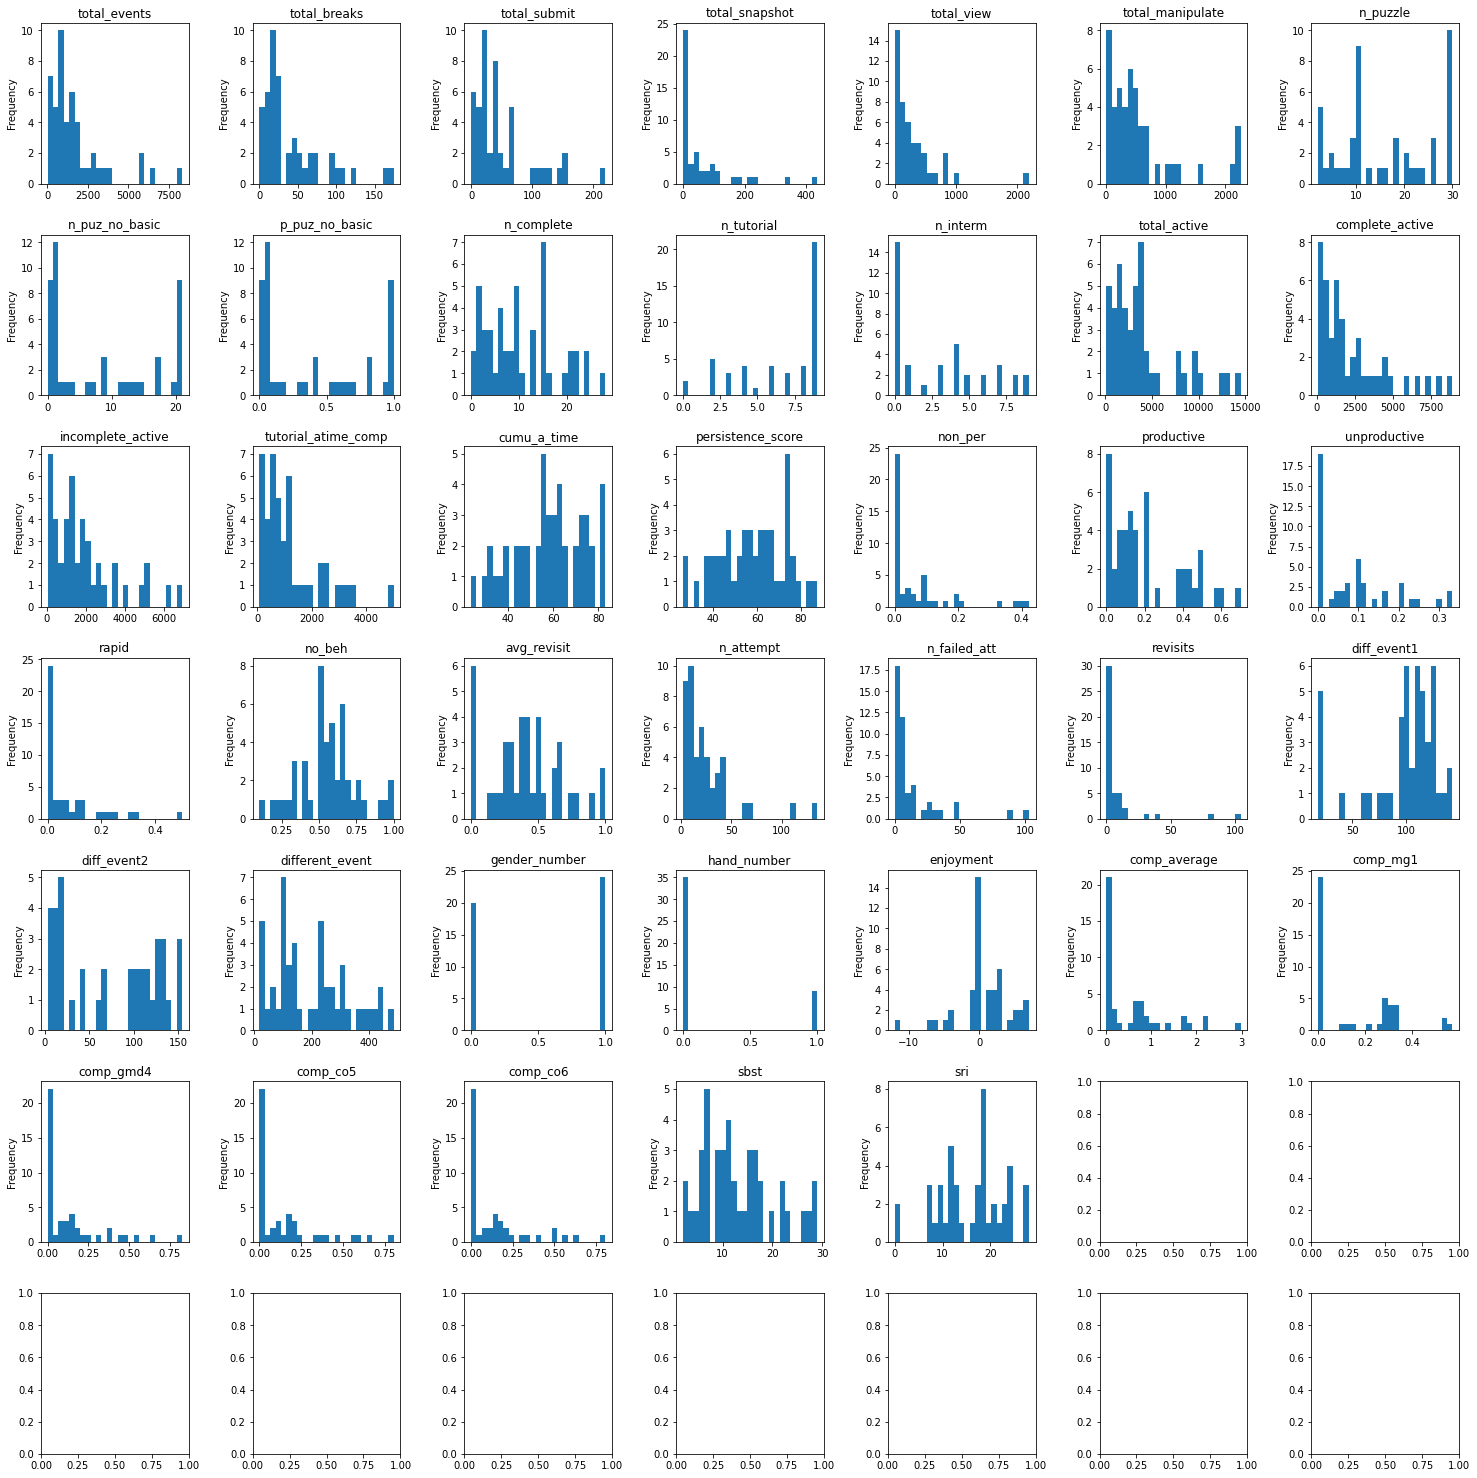

In [8]:
N = ceil(sqrt(len(everything)))
fig, axs = subplots(N, N)
fig.set_size_inches(3*N, 3*N)
fig.tight_layout(pad=3.0)
for i, col in enumerate(everything):
    data[col].plot(kind="hist", ax=axs[i//N][i%N], title=col, bins=25)

fig.savefig("output/hists.png")

In [9]:
# Percentages for the binary variables, gender and handedness
percent_female = len(data[data["gender_number"] == 1]) / len(data) * 100
print(f"Percent of students that are female: {percent_female:.4}")

percent_left = len(data[data["hand_number"] == 1]) / len(data) * 100
print(f"Percent of students that are left-handed: {percent_left:.4}")

Percent of students that are female: 51.06
Percent of students that are left-handed: 19.15


In [10]:
# Correlation analysis
corr = data[everything + corr_extras].corr()
corr.to_csv("output/corr.csv", sep="\t")
display(corr)

,total_events,total_breaks,total_submit,total_snapshot,total_view,total_manipulate,n_puzzle,n_puz_no_basic,p_puz_no_basic,n_complete,...,comp_average,comp_mg1,comp_gmd4,comp_co5,comp_co6,sbst,sri,so,mr,sv
total_events,1.000000,0.645940,0.831245,0.878537,0.873332,0.969912,0.729461,0.726490,0.726490,0.649441,...,0.516386,0.497771,0.515824,0.489629,0.500781,0.121307,0.080549,0.184750,0.041129,-0.032344
total_breaks,0.645940,1.000000,0.810802,0.430055,0.321672,0.752608,0.635879,0.622537,0.622537,0.480924,...,0.352630,0.299691,0.369437,0.337552,0.357125,-0.016558,0.022078,0.122771,0.007396,-0.092071
total_submit,0.831245,0.810802,1.000000,0.549738,0.566189,0.878835,0.738982,0.730438,0.730438,0.552429,...,0.384053,0.451743,0.354749,0.343395,0.350367,-0.011722,-0.112170,0.003562,-0.090324,-0.231466
total_snapshot,0.878537,0.430055,0.549738,1.000000,0.878556,0.802186,0.528741,0.534731,0.534731,0.588544,...,0.504212,0.425537,0.527523,0.494122,0.502334,0.203829,0.229070,0.311935,0.140318,0.139044
total_view,0.873332,0.321672,0.566189,0.878556,1.000000,0.754409,0.537787,0.526580,0.526580,0.590044,...,0.483654,0.453014,0.489970,0.463884,0.468535,0.124007,0.111049,0.155391,0.086237,0.038972
total_manipulate,0.969912,0.752608,0.878835,0.802186,0.754409,1.000000,0.763683,0.762474,0.762474,0.640513,...,0.500843,0.478564,0.501010,0.474208,0.489402,0.136284,0.099319,0.215545,0.057908,-0.034115
n_puzzle,0.729461,0.635879,0.738982,0.528741,0.537787,0.763683,1.000000,0.979048,0.979048,0.842271,...,0.752968,0.746699,0.722804,0.726158,0.728326,0.302955,0.129835,0.137527,0.104886,0.094333
n_puz_no_basic,0.726490,0.622537,0.730438,0.534731,0.526580,0.762474,0.979048,1.000000,1.000000,0.809996,...,0.763856,0.748337,0.737328,0.738345,0.741180,0.294247,0.175193,0.167689,0.167589,0.115758
p_puz_no_basic,0.726490,0.622537,0.730438,0.534731,0.526580,0.762474,0.979048,1.000000,1.000000,0.809996,...,0.763856,0.748337,0.737328,0.738345,0.741180,0.294247,0.175193,0.167689,0.167589,0.115758
n_complete,0.649441,0.480924,0.552429,0.588544,0.590044,0.640513,0.842271,0.809996,0.809996,1.000000,...,0.938568,0.884899,0.911005,0.921175,0.921947,0.558489,0.323951,0.250184,0.298926,0.301309


In [11]:
# # p values
# pvals = DataFrame(calculate_pvalues(data[everything + corr_extras]))
# pvals.to_csv("output/pvals.csv", sep="\t")
# display(pvals)

In [12]:
# Cronbach's Alpha
alpha, _ = cronbach_alpha(data=data[["so", "mr", "sv"]])
print(f"Cronbach's Alpha for SRI facets: {alpha}")

alpha, _ = cronbach_alpha(data=data[[f"sbst{i}" for i in range(1,31)]])
print(f"Cronbach's Alpha for SBST facets: {alpha}")

Cronbach's Alpha for SRI facets: 0.8359066056875625
Cronbach's Alpha for SBST facets: 0.8990425510278549


# ANOVA

In [13]:
# ANOVA with SRI and gender
aov = anova(data=data, dv="sri", between="gender")
print("ANOVA of sri between gender:")
print(aov)
print()

aov = anova(data=data, dv="sbst", between="gender")
print("ANOVA of sbst between gender:")
print(aov)
print()

aov = anova(data=data, dv="n_complete", between="gender")
print("ANOVA of n_complete between gender:")
print(aov)
print()

# model0 = glm("sri ~ 1", data).fit()
# print(model0.summary())

# print()
# model1 = glm("sri ~ 1 + gender_number", data).fit()
# print(model1.summary())

# f_stat, p_value = calculate_nested_f_statistic(model0, model1)
# result = "fail to reject"
# if p_value < 0.05:
#     "reject"

# print()
# print(f"We {result} the null hypothesis in favor of the alternative that a linear\nmodel including the gender is a better predictor of sri than the mean\nalone (alpha=0.05, F={f_stat:.4}, p={p_value:.4}).")

ANOVA of sri between gender:
   Source  ddof1  ddof2         F    p-unc       np2
0  gender      1     42  1.777605  0.18963  0.040605

ANOVA of sbst between gender:
   Source  ddof1  ddof2         F     p-unc       np2
0  gender      1     39  1.834019  0.183449  0.044914

ANOVA of n_complete between gender:
   Source  ddof1  ddof2         F     p-unc       np2
0  gender      1     42  0.614792  0.437389  0.014427



In [14]:
# # Same thing but with SBST
# model0 = glm("sbst ~ 1", data).fit()
# print(model0.summary())

# print()
# model1 = glm("sbst ~ 1 + gender_number", data).fit()
# print(model1.summary())

# f_stat, p_value = calculate_nested_f_statistic(model0, model1)
# result = "fail to reject"
# if p_value < 0.05:
#     "reject"

# print()
# print(f"We {result} the null hypothesis in favor of the alternative that a linear\nmodel including the gender is a better predictor of sbst than the mean\nalone (alpha=0.05, F={f_stat:.4}, p={p_value:.4}).")

In [15]:
# # Same thing but with n_complete
# model0 = glm("n_complete ~ 1", data).fit()
# print(model0.summary())

# print()
# model1 = glm("n_complete ~ 1 + gender_number", data).fit()
# print(model1.summary())

# f_stat, p_value = calculate_nested_f_statistic(model0, model1)
# result = "fail to reject"
# if p_value < 0.05:
#     "reject"

# print()
# print(f"We {result} the null hypothesis in favor of the alternative that a linear\nmodel including the gender is a better predictor of n_complete than the mean\nalone (alpha=0.05, F={f_stat:.4}, p={p_value:.4}).")

# Random Forest

In [16]:
# Helper to run all the steps for a given dependent variable and regressor
def run_regressor(good_data, dep_col, model_cols, subgroups, reg, title, ax_row):    
    # Split into train and test
    train_features, test_features, train_labels, test_labels = train_test_split(
        array(good_data[model_cols]),
        array(good_data[dep_col]),
        test_size=0.25,
        random_state=42
    )
    
    print("Training Features Shape:", train_features.shape)
    print("Training Labels Shape:", train_labels.shape)
    print("Testing Features Shape:", test_features.shape)
    print("Testing Labels Shape:", test_labels.shape)
    
    # Fit model
    reg.fit(train_features, train_labels)
    
    # Check goodness
    predictions = reg.predict(test_features)
    errors = abs(predictions - test_labels)
    print("Mean Absolute Error:", round(mean(errors), 2), "degrees.")
    
    # Check goodness, for comparing between subgroups
    good_data["Predicted"] = reg.predict(array(good_data[model_cols]))
    good_data["Errors"] = good_data["Predicted"] - good_data[dep_col]
    display(good_data[["Errors", *subgroups]].corr())
    
#     # Display importance of each features
#     gini_importances = list(rf.feature_importances_)
    # perm_importances = permutation_importance(reg, features, labels)["importances_mean"]
#     importances = [
#         (feature, round(gini, 2), round(perm, 2))
#         for feature, gini, perm
#         in zip(list(good_data.drop(dep_col, axis=1).columns), gini_importances, perm_importances)
#     ]

#     importances = sorted(importances, reverse=True, key=lambda x: x[1])
#     for feature, gini, perm in importances:
#         print(f"Variable: {feature:20} Gini Importance: {gini:<5} Permutation Importance: {perm}")
    
    # Plot actual vs. predicted, color coded for each subgroup
    for i, group in enumerate(subgroups):
        good_data.plot(
            kind="scatter",
            ax=ax_row[i],
            x=dep_col,
            y="Predicted",
            c=group,
            cmap=get_cmap("Spectral"),
            title=title
        )

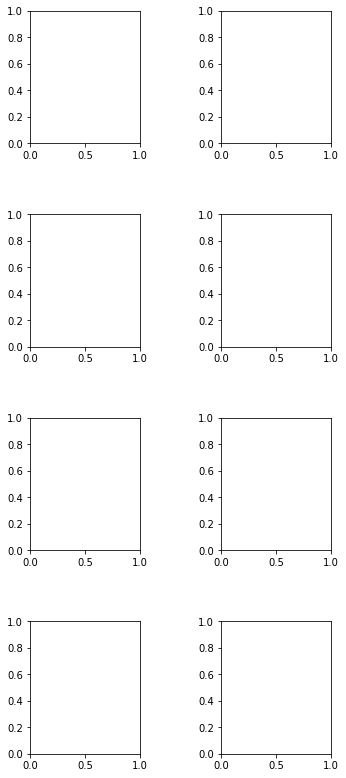

In [17]:
# setup figure that we'll add all the prediction plots to
cols = 2
rows = 4
fig, axs = subplots(rows, cols)
fig.set_size_inches(3*cols, 3*rows)
fig.tight_layout(pad=5.0)

In [18]:
# run the models
good_data = data[data["sri"] > 0][everything].dropna()
reg = XGBRegressor(tree_method="hist", random_state=42)
run_regressor(good_data, "sri", features, ["gender_number"], reg, "sri xgb full", axs[0])

Training Features Shape: (22, 38)
Training Labels Shape: (22,)
Testing Features Shape: (8, 38)
Testing Labels Shape: (8,)
Mean Absolute Error: 3.63 degrees.


,Errors,gender_number
Errors,1.000000,-0.061059
gender_number,-0.061059,1.000000


In [19]:
good_data = data[data["sbst"] > 0][everything].dropna()
reg = XGBRegressor(tree_method="hist", random_state=42)
run_regressor(good_data, "sbst", features, ["gender_number"], reg, "sbst xgb full model", axs[1])

Training Features Shape: (23, 38)
Training Labels Shape: (23,)
Testing Features Shape: (8, 38)
Testing Labels Shape: (8,)
Mean Absolute Error: 5.0 degrees.


,Errors,gender_number
Errors,1.000000,0.202713
gender_number,0.202713,1.000000


In [20]:
good_data = data[data["sri"] > 0][everything].dropna()
reg = RandomForestRegressor(n_estimators=1000, random_state=42)
run_regressor(good_data, "sri", features, ["gender_number"], reg, "sri rf full model", axs[2])

Training Features Shape: (22, 38)
Training Labels Shape: (22,)
Testing Features Shape: (8, 38)
Testing Labels Shape: (8,)
Mean Absolute Error: 4.46 degrees.


,Errors,gender_number
Errors,1.000000,0.136004
gender_number,0.136004,1.000000


In [21]:
good_data = data[data["sbst"] > 0][everything].dropna()
reg = RandomForestRegressor(n_estimators=1000, random_state=42)
run_regressor(good_data, "sbst", features, ["gender_number"], reg, "sbst rf full model", axs[3])

Training Features Shape: (23, 38)
Training Labels Shape: (23,)
Testing Features Shape: (8, 38)
Testing Labels Shape: (8,)
Mean Absolute Error: 4.99 degrees.


,Errors,gender_number
Errors,1.000000,0.156391
gender_number,0.156391,1.000000


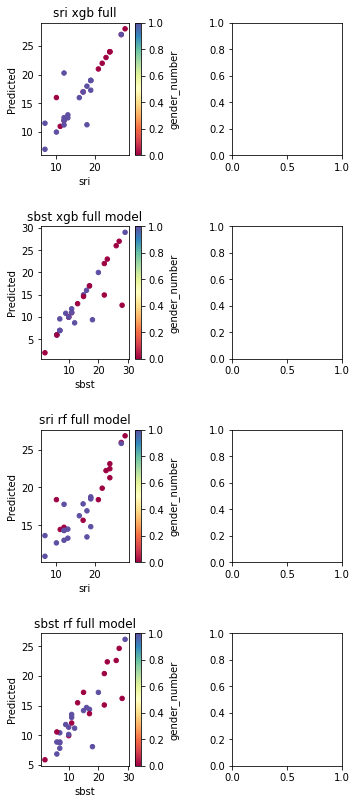

In [22]:
# save the plot now that we're done
fig.savefig(f"output/predictions.png")
display(fig)